##### https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

In [2]:
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterGrid, KFold, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score, jaccard_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle

from sklearn.base import BaseEstimator

from functions__ import print_scores
from functions__ import print_best_model
from functions__ import print_feature_importance
from functions__ import create_bins
from functions__ import multiply_columns
from functions__ import create_target
from functions__ import modify_columns
from functions__ import sample_df
from functions__ import create_target_df
from functions__ import show_counts
from functions__ import create_train_test

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_parquet("train_final.parquet")

print(train_df.shape)
train_df.head(2)

(94049, 58)


,id,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,5beefd4d2bf4a4767e0df8108,10,5245.571,981.182,205.948,VODAFONE TR,Apple,-1.197737,1.113360,-1.123334,...,-2.613336,-2.032903,2.645719,-1.023478,1.658986,-1.559406,-2.161336,30,58,"menu2, menu4, menu5"
1,867285b116c063d5a8482f5be,10,5184.876,557.650,487.587,TURKCELL,samsung,-2.336352,2.567766,-0.494908,...,-0.983938,-1.453756,-0.021547,-0.195770,2.775513,-0.318980,-4.291473,21,45,"menu7, menu8, menu4"


In [4]:
create_target(train_df)

first, second, third = modify_columns(train_df)

df_with_menus = pd.concat([first, second, third]).pivot_table(index = ['id', "month"], columns = 'menu', values = 'n_seconds')

train_v2_df = pd.merge(left = train_df, right = df_with_menus, left_on = ["id", "month"], right_on = ["id", "month"], how = 'left')
train_v2_df.drop(["first_menu", "second_menu", "third_menu"], axis = 1, inplace = True)

feature_flag = []
for val in train_v2_df.columns[train_v2_df.columns.str.contains("feature")]:
    feature_flag.append(val)
print(feature_flag)

n_seconds_flag = []
for val in train_v2_df.columns[train_v2_df.columns.str.contains("n_seconds")]:
    n_seconds_flag.append(val)
print(n_seconds_flag)

categoric_flag = ["carrier", "devicebrand"]
print(categoric_flag)

target_flag = []
for val in train_v2_df.columns[train_v2_df.columns.str.contains("target_")]:
    target_flag.append(val)
print(target_flag)

continuous_flag = feature_flag + n_seconds_flag
print(continuous_flag)

multi_flag = []

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49']
['n_seconds_1', 'n_seconds_2', 'n_seconds_3']
['carrier', 'devicebrand']
['target_1', 'target_2', 'target_3', 'target_4', 'target_5', 'target_6', 'target_7', 'target_8', 'target_9']
['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_

In [5]:
dataframes_of_targets = create_target_df(train_v2_df, feature_flag, n_seconds_flag, categoric_flag, multi_flag)

target_1_df = dataframes_of_targets[0]
target_2_df = dataframes_of_targets[1]
target_3_df = dataframes_of_targets[2]
target_4_df = dataframes_of_targets[3]
target_5_df = dataframes_of_targets[4]
target_6_df = dataframes_of_targets[5]
target_7_df = dataframes_of_targets[6]
target_8_df = dataframes_of_targets[7]
target_9_df = dataframes_of_targets[8]

In [6]:
X8 = target_8_df.drop("target_8", axis = 1)
y8 = target_8_df.target_8

X8_train, X8_test, y8_train, y8_test = train_test_split(X8, y8, test_size = 0.2, random_state = 1, stratify = y8)

In [7]:
class DeviceBrandTransformer(BaseEstimator):
  def __init__(self, feature_name, test_feature, additional_param = "devicebrand_v2"):  
    self.feature_name = feature_name
    self.test_feature = test_feature
    self.additional_param = additional_param


  def fit(self, X, y = None):
    print(f'\nfeature_name is {self.feature_name}')
    print(f'\ntest_feature is {self.test_feature}')
    print(f'\nadditional param is {self.additional_param}\n')
    
    return self


  def transform(self, X, y = None):
    X_ = X.copy()
    X_[self.feature_name] = X_[self.feature_name].apply(lambda x: x.upper())
    X_[self.additional_param] = X_[self.feature_name].apply(lambda x: x if x in ["APPLE", "SAMSUNG"] else "OTHERS")
    X_[self.feature_name] = X_[self.feature_name].apply(lambda x: x if x in ["APPLE", "SAMSUNG"] else "OTHERS")
    
    if self.additional_param in X_.columns:
        X_dropped = X_.drop([self.additional_param], axis=1)
    else:
        X_dropped = X_

    self.columns = X_dropped.columns
    return X_dropped



class CarrierTransformer(BaseEstimator):
  def __init__(self, feature_name, test_feature, additional_param = "carrier_v2"):  
    self.feature_name = feature_name
    self.test_feature = test_feature
    self.additional_param = additional_param


  def fit(self, X, y = None):
    print(f'\nfeature_name is {self.feature_name}')
    print(f'\ntest_feature is {self.test_feature}')
    print(f'\nadditional param is {self.additional_param}\n')
    
    return self


  def transform(self, X, y = None):
    X_ = X.copy()
    X_[self.additional_param] = X_[self.feature_name].apply(lambda x: x if x in ["TURKCELL", "VODAFONE TR", "TURK TELEKOM"] else "OTHERS")
    X_[self.feature_name] = X_[self.feature_name].apply(lambda x: x if x in ["TURKCELL", "VODAFONE TR", "TURK TELEKOM"] else "OTHERS")
    
    if self.additional_param in X_.columns:
        X_dropped = X_.drop([self.additional_param], axis=1)
    else:
        X_dropped = X_

    self.columns = X_dropped.columns
    return X_dropped
  

  
numerical_pipe = Pipeline([
        ('scaler', RobustScaler())
    ])
categorical_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
    ])
preprocessors = ColumnTransformer(transformers = [
        ('num', numerical_pipe, continuous_flag),
        ('cat', categorical_pipe, categoric_flag)
    ])

classifier = lgb.LGBMClassifier(random_state = 1)

params = {"learning_rate": Real(0.01, 1.0, 'log-uniform'),
          "feature_fraction": Real(0.05, 1),
          "objective": Categorical(["binary"]),
          "metric": Categorical(["roc_auc"]),
          "lambda_l2": Real(1e-2, 100., 'uniform'),
          "num_leaves": Integer(4, 16),
          "max_depth": Integer(4, 16),
          "min_data_in_leaf": Integer(100, 500),
          "min_split_gain": Real(0.0001, 0.1),
          "min_child_weight": Real(0.0001, 0.1),
          "n_estimators": Integer(60, 200),
          "importance_type": Categorical(["gain"])
}

stratifiedKFold = StratifiedKFold(n_splits = 3, random_state = 1, shuffle = True)
bayesCV = BayesSearchCV(estimator = classifier, search_spaces = params, cv = stratifiedKFold, verbose = 1, n_iter = 5, n_jobs = -1)

target_8_model = Pipeline([
        ('replace_device_brand', DeviceBrandTransformer('devicebrand', 'test2')),
        ('replace_carrier', CarrierTransformer('carrier', 'test3')),
        ('preprocessors', preprocessors),
        ('model', bayesCV)
    ])


target_8_model.fit(X8_train, y8_train)


feature_name is devicebrand

test_feature is test2

additional param is devicebrand_v2


feature_name is carrier

test_feature is test3

additional param is carrier_v2

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] feature_fraction is set=0.4278032088161421, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4278032088161421
[LightGBM] [Warning] min_data_in_leaf is set=484, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=484
[LightGBM] [Warning] lambda_l2 is set=51.38056823725844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.38056823725844


Pipeline(steps=[('replace_device_brand',
                 DeviceBrandTransformer(feature_name='devicebrand',
                                        test_feature='test2')),
                ('replace_carrier',
                 CarrierTransformer(feature_name='carrier',
                                    test_feature='test3')),
                ('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['feature_0', 'feature_1',
                                                   'feature_2', 'feature_3',
                                                   'fea...
                                              'min_data_in_leaf': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                                              'min_split_gain': Real(low=0.0001, high=0.1, prior='uniform', transform='normalize'),
                                              'n_estimators': Integer(low=60, high=200, prior='uniform', transform='normalize'),
                                              'num_leaves': Integer(low=4, high=16, prior='uniform', transform='normalize'),
                                              'objective': Categorical(categories=('binary',), prior=None)},
                               verbose=1))])


 The best estimator:
 LGBMClassifier(feature_fraction=0.4278032088161421, importance_type='gain',
               lambda_l2=51.38056823725844, learning_rate=0.25173040622235526,
               max_depth=7, metric='roc_auc',
               min_child_weight=0.02143286885799221, min_data_in_leaf=484,
               min_split_gain=0.0003272562829843066, n_estimators=193,
               num_leaves=16, objective='binary', random_state=1)

 The best estimator:
 OrderedDict([('feature_fraction', 0.4278032088161421), ('importance_type', 'gain'), ('lambda_l2', 51.38056823725844), ('learning_rate', 0.25173040622235526), ('max_depth', 7), ('metric', 'roc_auc'), ('min_child_weight', 0.02143286885799221), ('min_data_in_leaf', 484), ('min_split_gain', 0.0003272562829843066), ('n_estimators', 193), ('num_leaves', 16), ('objective', 'binary')])

 The best score:
 0.7270823986840137


Accuracy score for train 1: 0.7929
Accuracy score for test 1: 0.7330
Precision score for train 1: 0.8009
Precision score

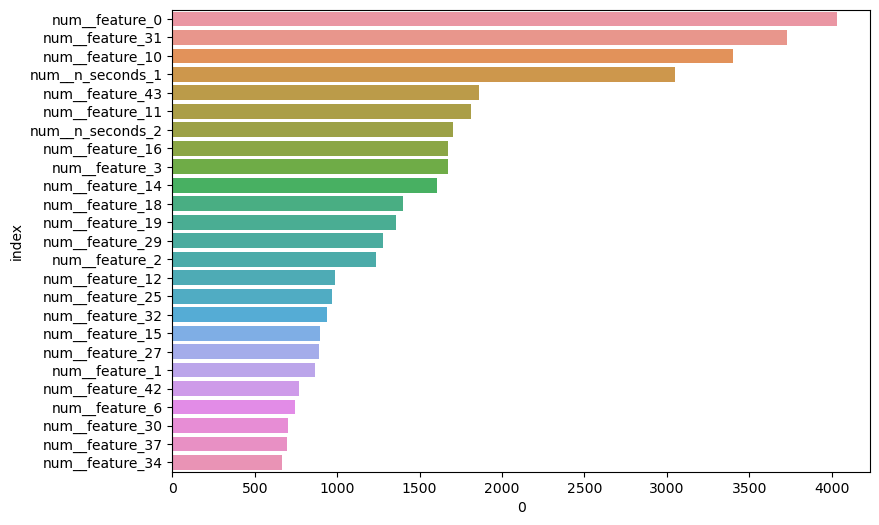

In [8]:
target_models = [target_8_model]
X_train_list = [X8_train]
y_train_list = [y8_train]

X_test_list = [X8_test]
y_test_list = [y8_test]

print_best_model(target_models)
print_scores(X_train_list, y_train_list, X_test_list, y_test_list, target_models)
print_feature_importance(target_models)

In [9]:
create_bins(X8_test, y8_test, target_8_model)

   bin  max_skor  toplam  good   bad     good%
9    1  0.996285    1171  1063   108  0.907771
8    2  0.884334    1170   965   205  0.824786
7    3  0.787376    1170   870   300  0.743590
6    4  0.687818    1170   763   407  0.652137
5    5  0.584993    1170   626   544  0.535043
4    6  0.484998    1171   483   688  0.412468
3    7  0.389585    1170   402   768  0.343590
2    8  0.301515    1170   327   843  0.279487
1    9  0.220872    1170   223   947  0.190598
0   10  0.142089    1171   130  1041  0.111016


In [10]:
with open('target_8_model_pipeline.pkl', 'wb') as file:
    pickle.dump(target_8_model, file)

In [11]:
loaded_target_8 = pickle.load(open("target_8_model_pipeline.pkl", "rb"))

In [12]:
test_df = pd.read_parquet("test_final.parquet")
test_df.set_index("id", inplace = True)

test_df.head(2)

,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
id,,,,,,,,,,,,,,,,,,,,,
2e6105f5911256f4f6c4813ed,1,6893.544,246.854,242.636,VODAFONE TR,samsung,-1.723524,3.216489,-1.138474,2.026997,...,-1.094519,-1.217407,-4.280456,1.512240,-2.306445,2.066388,0.844927,-1.026193,18,58
c56ad71dae0a5dbd3e7d36adc,1,4481.065,740.209,263.860,TURKCELL,Apple,-0.417275,2.024433,0.102952,-1.634336,...,1.806486,-3.477517,-2.064966,1.499805,1.284697,0.189269,-1.563224,-1.901654,3,35


In [13]:
probabilities8 = loaded_target_8.predict_proba(test_df)[:, 1]
test_df["target_8_score"] = probabilities8

test_df.head(2)

,month,n_seconds_1,n_seconds_2,n_seconds_3,carrier,devicebrand,feature_0,feature_1,feature_2,feature_3,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target_8_score
id,,,,,,,,,,,,,,,,,,,,,
2e6105f5911256f4f6c4813ed,1,6893.544,246.854,242.636,VODAFONE TR,samsung,-1.723524,3.216489,-1.138474,2.026997,...,-1.217407,-4.280456,1.512240,-2.306445,2.066388,0.844927,-1.026193,18,58,0.824715
c56ad71dae0a5dbd3e7d36adc,1,4481.065,740.209,263.860,TURKCELL,Apple,-0.417275,2.024433,0.102952,-1.634336,...,-3.477517,-2.064966,1.499805,1.284697,0.189269,-1.563224,-1.901654,3,35,0.491213
4d02ea175f6581f0c6385311f,1,4340.702,2742.163,318.700,TURKCELL,samsung,-2.943294,2.769536,0.734942,1.681471,...,-2.038839,-2.067219,2.141083,0.055355,0.084739,-1.009925,-2.058473,7,50,0.981614
3412d27a86c286ba078fa935c,1,4129.666,181.397,155.423,TURK TELEKOM,Apple,-2.346902,2.684752,0.168206,-1.072321,...,-0.925040,-1.484278,0.666036,0.911519,0.616167,0.092304,-1.874706,22,47,0.842349
0203b561f6f7e10eafa46eefa,1,3903.944,126.133,100.060,TURKCELL,POCO,-1.745354,2.355863,0.318961,-0.570734,...,-0.015773,-2.961445,1.301413,1.375090,-0.107355,0.924390,-1.606419,29,52,0.906560
48f7136bb578f892f1a93b752,1,3703.963,684.821,235.747,VODAFONE TR,Apple,-2.062765,0.527187,-1.056663,1.279828,...,-0.295926,-1.482033,1.472223,1.561179,0.312105,0.199395,-3.286957,18,37,0.384538
7e34aa3f61203ef82966ae181,1,3644.915,760.480,90.408,VODAFONE TR,samsung,-1.155180,1.745576,-0.174126,-0.734278,...,-0.733307,-1.502372,0.630243,1.004542,-0.413720,-0.936952,-3.573084,13,77,0.551723
262d1d878ef792a70c5f96c6a,1,3547.083,292.976,271.479,TURKCELL,Apple,-2.750095,2.258823,0.643613,-0.164362,...,-0.656412,-1.668977,0.767634,0.149959,0.768290,0.880114,-2.992260,35,71,0.868922
e1d34d0e17390f8d9d3804ce6,1,3444.672,470.941,90.780,TURK TELEKOM,Apple,-2.092186,2.598784,1.109748,1.121790,...,-1.545018,-1.418920,2.008713,0.137699,0.077054,0.000738,-2.028208,29,59,0.935859
